# Final exam code

The source code for resolving the exercises of the final exam for GRA4153 question 3

## Dependencies for the code
Feel free to colapse this header for clearity

For this code, the following libraries are necessary:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

The Classes necessary for this notebook are defined first, then the functions used, then the main body of the code is found futher below

### Classes

In [29]:
class Data:
    def __init__(self, target_CSV: str):
        '''
        Performs the necessary ETL and stages the data into a appropriate object
        '''
        self._raw_data = pd.read_csv(target_CSV)

        # Ensure observation_date is datetime
        self._raw_data['observation_date'] = pd.to_datetime(self._raw_data['observation_date'])
        self._raw_data.set_index('observation_date', inplace=True)
        self._sample = self._raw_data
        
    def set_sample_range(self, start_date: str, end_date: str):
        '''
        A setter method for the sample attribute that filters the raw data based on a date range.
        
        :param start_date: The start date for filtering
        :type start_date: str
        :param end_date: The end date for filtering
        :type end_date: str
        '''
        self._sample = self._raw_data.loc[start_date:end_date]
        
    @property
    def sample(self):
        return self._sample
    
    @sample.setter
    def sample(self, new_sample: pd.DataFrame):
        self._sample = new_sample

### Functions

In [30]:
def test_unit_root(df):
    '''
    Performs a unit test on a time series.
    
    :param df: DataFrame with time series data
    :type df: pd.DataFrame
    
    Prints:
    Test statistic, p-value, and conclusion about stationarity.
    '''
    # Run ADF test
    result = adfuller(df)

    # Unpack results
    test_statistic = result[0]
    p_value = result[1]
    used_lags = result[2]
    n_obs = result[3]
    critical_values = result[4]
    ic_best = result[5]

    # Print results
    print("ADF Test Statistic:", test_statistic)
    print("p-value:", p_value)
    print("Used Lags:", used_lags)
    print("Number of Observations:", n_obs)
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"   {key}: {value:.4f}")
    print("Information Criterion (best):", ic_best)

    # Conclusion
    if p_value < 0.05:
        print("\nConclusion: Reject the null hypothesis — the series is stationary.")
    else:
        print("\nConclusion: Fail to reject the null hypothesis — the series has a unit root (nonstationary).")

In [31]:
def plot_acf_pacf(df, lags=40):
    '''
    Plots ACF and PACF of the first-differenced INDPRO series.

    :param df: DataFrame with time series data
    :type df: pd.DataFrame
    :param lags: Number of lags to include in the plots
    :type lags: int
    :return: A plot with ACF and PACF together
    '''
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    plot_acf(df['INDPRO'], lags=lags, ax=axes[0])
    axes[0].set_title('ACF of Differenced INDPRO')

    plot_pacf(df['INDPRO'], lags=lags, ax=axes[1], method='ywm')
    axes[1].set_title('PACF of Differenced INDPRO')

    plt.tight_layout()
    

In [ ]:
def correct_aic(model_result):
    '''
    Computes AICC from a fitted ARIMA model result.

    :param model_result: Fitted ARIMA model result
    '''
    n = model_result.nobs
    k = model_result.df_model
    aic = model_result.aic
    return aic + (2 * k * (k + 1)) / (n - k - 1)

In [ ]:
def fit_arma_models(series, max_order=4):
    '''
    Fits ARMA(p,q) models to differenced INDPRO series and compares AICC and BIC.

    :param df: DataFrame with differenced time series
    :type df: pd.DataFrame
    :param max_order: Maximum value for p and q
    :type max_order: int

    Returns:
    pd.DataFrame: Table of (p,q), AICC, BIC
    '''
    results = []

    for p in range(max_order + 1):
        for q in range(max_order + 1):
            try:
                model = ARIMA(series, order=(p, 0, q))
                result = model.fit()
                aicc = correct_aic(result)
                bic = result.bic
                results.append({'p': p, 'q': q, 'AICC': aicc, 'BIC': bic})
            except Exception as e:
                continue  # Skip models that fail to converge

    return pd.DataFrame(results).sort_values(by='AICC')

## Main code

### Q3.i
Selecting the correct sample for evaluating

In [32]:
indpro = Data("indpro.csv")
indpro.set_sample_range("1970-01-01", "2015-12-01")
indpro.sample.head(20)

,INDPRO
observation_date,
1970-01-01,37.9288
1970-02-01,37.9038
1970-03-01,37.8546
1970-04-01,37.7573
1970-05-01,37.7133
1970-06-01,37.5913
1970-07-01,37.6836
1970-08-01,37.6164
1970-09-01,37.3571


<Axes: title={'center': 'Time Series of INDPRO'}, xlabel='Date', ylabel='INDPRO'>

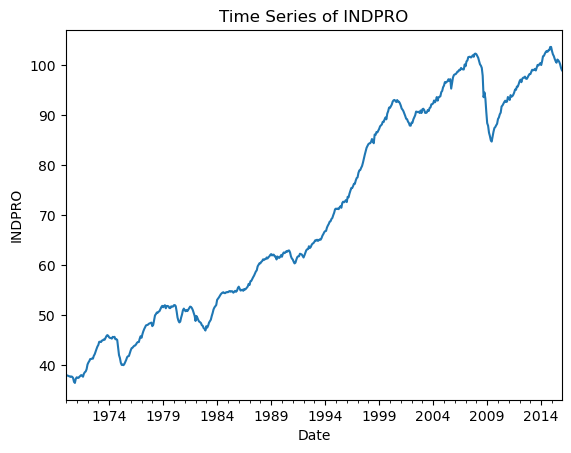

In [33]:
indpro.sample["INDPRO"].plot(title='Time Series of INDPRO', ylabel='INDPRO', xlabel='Date')

### Q3.ii
Testing for unit root of INDPRO data

In [34]:
test_unit_root(indpro.sample)

ADF Test Statistic: -1.0482117364544745
p-value: 0.7352768013756509
Used Lags: 4
Number of Observations: 547
Critical Values:
   1%: -3.4424
   5%: -2.8668
   10%: -2.5696
Information Criterion (best): 684.5104405539611

Conclusion: Fail to reject the null hypothesis — the series has a unit root (nonstationary).


### Q.iii
Correcting for the unit root

In [35]:
indpro.sample = indpro.sample.diff().dropna()
test_unit_root(indpro.sample)

ADF Test Statistic: -6.561947563095948
p-value: 8.338738663782002e-09
Used Lags: 3
Number of Observations: 547
Critical Values:
   1%: -3.4424
   5%: -2.8668
   10%: -2.5696
Information Criterion (best): 682.0742060108141

Conclusion: Reject the null hypothesis — the series is stationary.


### Q.iv
Ploting ACF and PACF

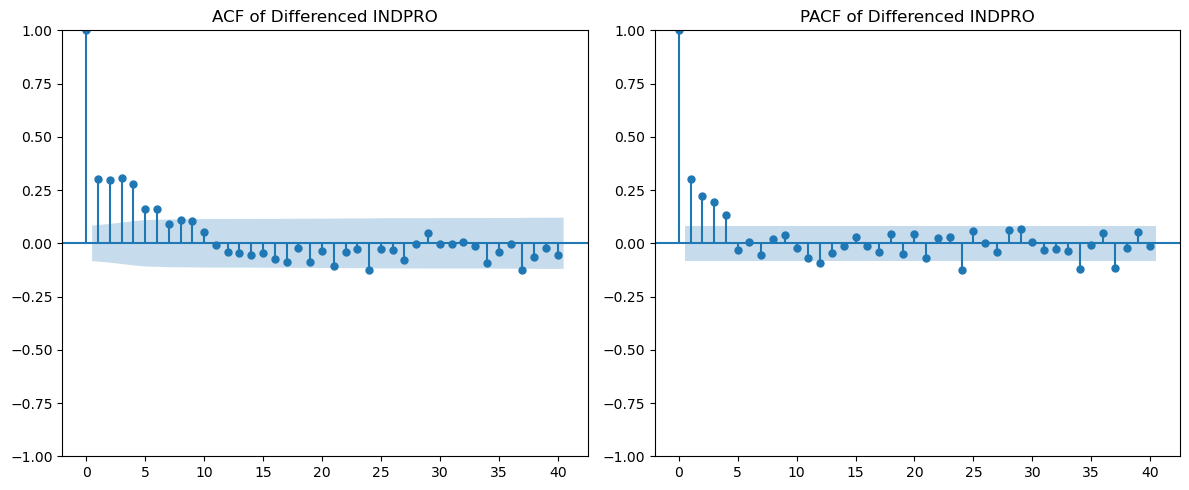

In [36]:
plot_acf_pacf(indpro.sample)

### Q.v
Model selection